<a href="https://colab.research.google.com/github/fatimaiqbal27/Underwater-Turbid-Image-Restoration-Using-Diffusion-Models/blob/main/denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

iqbalfatimah271_train_data_path = kagglehub.dataset_download('iqbalfatimah271/train-data')
iqbalfatimah271_test_image_1_path = kagglehub.dataset_download('iqbalfatimah271/test-image-1')
iqbalfatimah271_test_image_2_path = kagglehub.dataset_download('iqbalfatimah271/test-image-2')
iqbalfatimah271_test_image_5_path = kagglehub.dataset_download('iqbalfatimah271/test-image-5')
iqbalfatimah271_testdata909_path = kagglehub.dataset_download('iqbalfatimah271/testdata909')
iqbalfatimah271_45654646_path = kagglehub.dataset_download('iqbalfatimah271/45654646')
iqbalfatimah271_dataset2024_path = kagglehub.dataset_download('iqbalfatimah271/dataset2024')
iqbalfatimah271_underwater_path = kagglehub.dataset_download('iqbalfatimah271/underwater')
iqbalfatimah271_noisyimagefish_path = kagglehub.dataset_download('iqbalfatimah271/noisyimagefish')
iqbalfatimah271_datasetserhat_path = kagglehub.dataset_download('iqbalfatimah271/datasetserhat')
iqbalfatimah271_serhat2_path = kagglehub.dataset_download('iqbalfatimah271/serhat2')
iqbalfatimah271_serhat3_path = kagglehub.dataset_download('iqbalfatimah271/serhat3')
iqbalfatimah271_serhat7_path = kagglehub.dataset_download('iqbalfatimah271/serhat7')
iqbalfatimah271_noisy_images_created_path = kagglehub.dataset_download('iqbalfatimah271/noisy-images-created')
iqbalfatimah271_clear_images_dataset_path = kagglehub.dataset_download('iqbalfatimah271/clear-images-dataset')
iqbalfatimah271_clear_a_path = kagglehub.dataset_download('iqbalfatimah271/clear-a')
iqbalfatimah271_noisy_b_path = kagglehub.dataset_download('iqbalfatimah271/noisy-b')
iqbalfatimah271_turbid_images_path = kagglehub.dataset_download('iqbalfatimah271/turbid-images')
iqbalfatimah271_clean_images_path = kagglehub.dataset_download('iqbalfatimah271/clean-images')
iqbalfatimah271_turbid_new_path = kagglehub.dataset_download('iqbalfatimah271/turbid-new')
iqbalfatimah271_serhat_45_path = kagglehub.dataset_download('iqbalfatimah271/serhat-45')
iqbalfatimah271_vignette_path = kagglehub.dataset_download('iqbalfatimah271/vignette')
iqbalfatimah271_video_frames_path = kagglehub.dataset_download('iqbalfatimah271/video-frames')
iqbalfatimah271_video_2_path = kagglehub.dataset_download('iqbalfatimah271/video-2')
iqbalfatimah271_underwater1_path = kagglehub.dataset_download('iqbalfatimah271/underwater1')
iqbalfatimah271_frames_video_path = kagglehub.dataset_download('iqbalfatimah271/frames-video')
iqbalfatimah271_jeff_turbidity_path = kagglehub.dataset_download('iqbalfatimah271/jeff-turbidity')
iqbalfatimah271_turbid_video_path = kagglehub.dataset_download('iqbalfatimah271/turbid-video')
iqbalfatimah271_kamera2_path = kagglehub.dataset_download('iqbalfatimah271/kamera2')
iqbalfatimah271_kamera3_trim_path = kagglehub.dataset_download('iqbalfatimah271/kamera3-trim')

print('Data source import complete.')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
import os
from PIL import Image

# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU()
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2, 2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.final_conv(dec1)

# Custom Dataset Class
class UnderwaterDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_images = sorted(os.listdir(noisy_dir))
        self.clean_images = sorted(os.listdir(clean_dir))
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.transform = transform

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        noisy_img = Image.open(os.path.join(self.noisy_dir, self.noisy_images[idx])).convert("RGB")
        clean_img = Image.open(os.path.join(self.clean_dir, self.clean_images[idx])).convert("RGB")

        if self.transform:
            noisy_img = self.transform(noisy_img)
            clean_img = self.transform(clean_img)

        return noisy_img, clean_img

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = UnderwaterDataset(noisy_dir='/kaggle/input/turbid-new', clean_dir='/kaggle/input/clean-images', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for noisy, clean in dataloader:
        noisy, clean = noisy.to(device), clean.to(device)

        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.6f}")

# Save the model
torch.save(model.state_dict(), 'denoising_unet.pth')


Epoch 1/10, Loss: 12.416429
Epoch 2/10, Loss: 0.132679
Epoch 3/10, Loss: 0.029892
Epoch 4/10, Loss: 0.021160
Epoch 5/10, Loss: 0.019245
Epoch 6/10, Loss: 0.018108
Epoch 7/10, Loss: 0.017230
Epoch 8/10, Loss: 0.011890
Epoch 9/10, Loss: 0.008006
Epoch 10/10, Loss: 0.006976


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets, models
import os
from PIL import Image
import torch
import random
import numpy as np

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU()
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2, 2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.final_conv(dec1)

# Custom Dataset Class
class UnderwaterDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_images = sorted(os.listdir(noisy_dir))
        self.clean_images = sorted(os.listdir(clean_dir))
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.transform = transform

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        noisy_img = Image.open(os.path.join(self.noisy_dir, self.noisy_images[idx])).convert("RGB")
        clean_img = Image.open(os.path.join(self.clean_dir, self.clean_images[idx])).convert("RGB")

        if self.transform:
            noisy_img = self.transform(noisy_img)
            clean_img = self.transform(clean_img)

        return noisy_img, clean_img

# Loss Function: Combined L1 + Perceptual + Color Constancy
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        vgg = models.vgg16(weights=None).features[:16].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.to(device)
        self.l1 = nn.L1Loss()

    def perceptual_loss(self, input, target):
        return nn.functional.mse_loss(self.vgg(input), self.vgg(target))

    def color_constancy_loss(self, img):
        mean_rgb = img.mean(dim=[2, 3], keepdim=True)
        r, g, b = mean_rgb[:, 0], mean_rgb[:, 1], mean_rgb[:, 2]
        return ((r - g) ** 2 + (r - b) ** 2 + (g - b) ** 2).mean()

    def forward(self, input, target):
        l1_loss = self.l1(input, target)
        perceptual = self.perceptual_loss(input, target)
        color_loss = self.color_constancy_loss(input)
        return l1_loss + 0.1 * perceptual + 0.01 * color_loss

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = UnderwaterDataset(
    noisy_dir='/kaggle/input/turbid-new',
    clean_dir='/kaggle/input/clean-images',
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = UNet().to(device)
criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
set_seed(42)
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for noisy, clean in dataloader:
        noisy, clean = noisy.to(device), clean.to(device)

        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.6f}")

# Save the model
torch.save(model.state_dict(), 'denoising_unet.pth')


Epoch 1/10, Loss: 0.458826
Epoch 2/10, Loss: 0.121999
Epoch 3/10, Loss: 0.108937
Epoch 4/10, Loss: 0.095919
Epoch 5/10, Loss: 0.087801
Epoch 6/10, Loss: 0.106474
Epoch 7/10, Loss: 0.087890
Epoch 8/10, Loss: 0.087155
Epoch 9/10, Loss: 0.084850
Epoch 10/10, Loss: 0.084271


In [ ]:

def pad_to_divisible_by_16(image):
    """
    Pad the input image to make its dimensions divisible by 16.
    """
    _, h, w = image.shape
    pad_h = (16 - h % 16) % 16
    pad_w = (16 - w % 16) % 16
    return F.pad(image, (0, pad_w, 0, pad_h)), (h, w)  # Return original size for cropping later

def crop_to_original_size(output, original_size):
    """
    Crop the output to match the original input dimensions.
    """
    h, w = original_size  # original_size is (h, w)
    return output[:, :h, :w]

In [ ]:
from IPython.display import FileLink
FileLink('/kaggle/working/denoising_unet.pth')



/kaggle/working/denoising_unet.pth

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<ipython-input-5-8af12397023e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/denoising_unet.pth'))  # Use weights_only=T

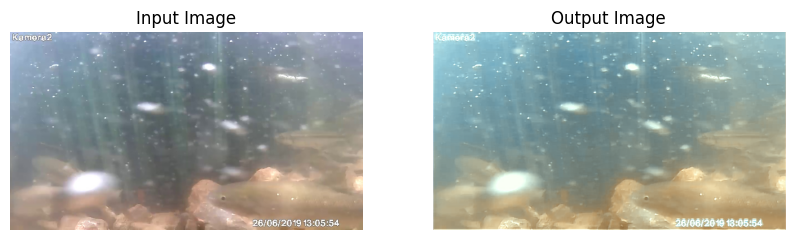

In [ ]:


import matplotlib.pyplot as plt
import torch.nn.functional as F
# Load the trained model
model = UNet().to(device)
model.load_state_dict(torch.load('/kaggle/working/denoising_unet.pth'))  # Use weights_only=True for safety
model.eval()

# Load and preprocess the input image
input_image = Image.open('/kaggle/input/video-frames/frame_019.jpg').convert("RGB")
transform = transforms.Compose([
    transforms.ToTensor()
])
input_tensor = transform(input_image).unsqueeze(0).to(device)  # Add batch dimension

# Pad the input image
input_tensor_padded, original_size = pad_to_divisible_by_16(input_tensor.squeeze(0))
input_tensor_padded = input_tensor_padded.unsqueeze(0).to(device)

# Forward pass
with torch.no_grad():
    output_tensor_padded = model(input_tensor_padded)

# Crop the output to match the original input dimensions
output_tensor = crop_to_original_size(output_tensor_padded.squeeze(0), original_size)

# Ensure the output tensor has shape (C, H, W)
output_tensor = output_tensor.squeeze(0)  # Remove batch dimension if present

# Convert output to image
output_image = transforms.ToPILImage()(torch.clamp(output_tensor.cpu(), 0, 1))


# Save the output image
output_image.save('output_image.jpg')

# Display input and output images side by side
plt.figure(figsize=(10, 5))

# Display input image
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Input Image")
plt.axis("off")

# Display output image
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title("Output Image")
plt.axis("off")

plt.show()

<ipython-input-8-1228cde9912a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/denoising_unet.pth'))  # Use weights_only=T

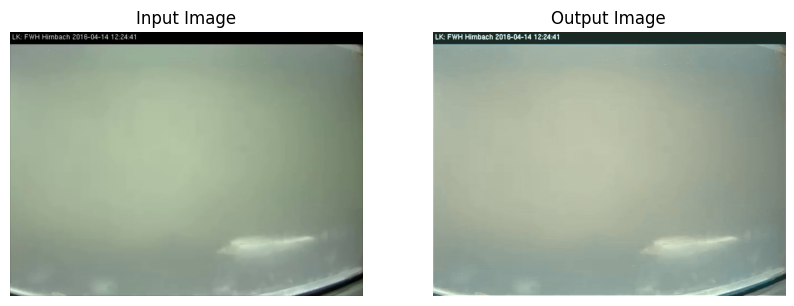

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
# Load the trained model
model = UNet().to(device)
model.load_state_dict(torch.load('/kaggle/working/denoising_unet.pth'))  # Use weights_only=True for safety
model.eval()

# Load and preprocess the input image
input_image = Image.open('/kaggle/input/frames-video/frame_00031.jpg').convert("RGB")
transform = transforms.Compose([
    transforms.ToTensor()
])
input_tensor = transform(input_image).unsqueeze(0).to(device)  # Add batch dimension

# Pad the input image
input_tensor_padded, original_size = pad_to_divisible_by_16(input_tensor.squeeze(0))
input_tensor_padded = input_tensor_padded.unsqueeze(0).to(device)

# Forward pass
with torch.no_grad():
    output_tensor_padded = model(input_tensor_padded)

# Crop the output to match the original input dimensions
output_tensor = crop_to_original_size(output_tensor_padded.squeeze(0), original_size)

# Ensure the output tensor has shape (C, H, W)
output_tensor = output_tensor.squeeze(0)  # Remove batch dimension if present

# Convert output to image
output_image = transforms.ToPILImage()(torch.clamp(output_tensor.cpu(), 0, 1))


# Save the output image
output_image.save('output_image.jpg')

# Display input and output images side by side
plt.figure(figsize=(10, 5))

# Display input image
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Input Image")
plt.axis("off")

# Display output image
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title("Output Image")
plt.axis("off")

plt.show()

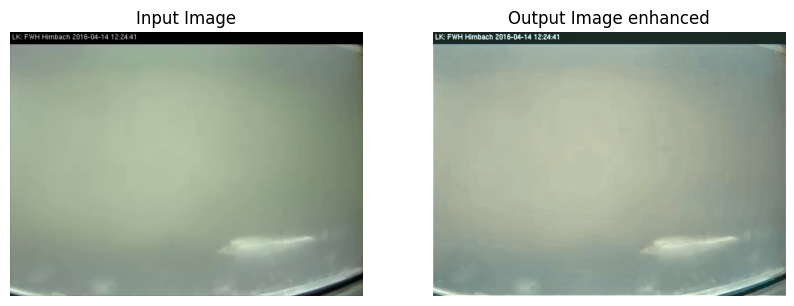

In [ ]:
import cv2

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def postprocess(image_tensor):
    # Move tensor to CPU first
    image_np = image_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
    image_np = (np.clip(image_np, 0, 1) * 255).astype(np.uint8)

    # Convert to LAB and apply CLAHE to the L-channel
    lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=0.4, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

    return enhanced

# Postprocess output
out_np = postprocess(output_tensor)

# Convert enhanced numpy image to PIL image
output_upgraded = transforms.ToPILImage()(torch.from_numpy(out_np).permute(2, 0, 1).float() / 255)

# Save the output image
output_upgraded.save('output_image_enhanced.jpg')

# Display input and output images side by side
plt.figure(figsize=(10, 5))

# Display input image
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Input Image")
plt.axis("off")




# Display output image
plt.subplot(1, 2, 2)
plt.imshow(output_upgraded)
plt.title("Output Image enhanced")
plt.axis("off")

plt.show()


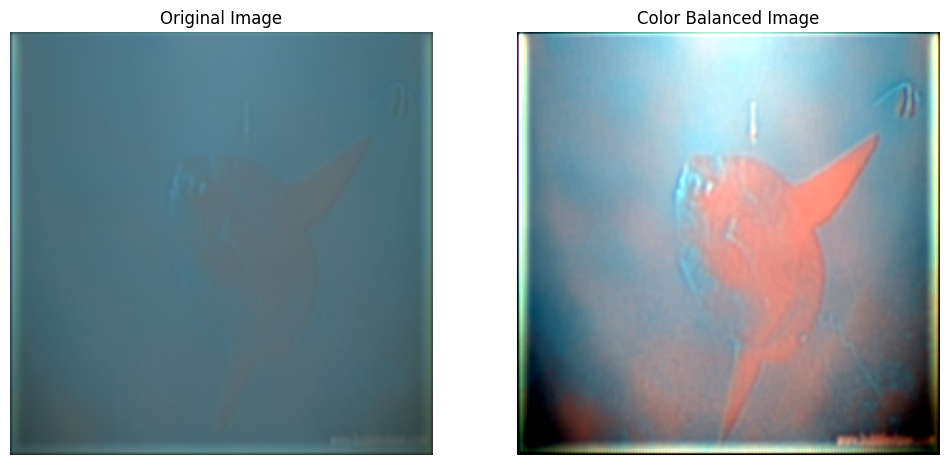

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

class AdaptiveColorBalance:
    def __init__(self):
        # Instead of fixed initial values, start with None and initialize dynamically
        self.low_values = None
        self.high_values = None

    def apply(self, image, clip_value=0.01, learn_rate=0.00005, preserve_shades=True):
        """
        ✅ Improvements:
        - **Preserves color shades** using weighted adjustment.
        - **Adaptive learning without drastic changes.**
        - **Smooth transition instead of harsh normalization.**
        """

        channels = cv2.split(image)
        balanced_channels = []

        # Initialize low/high values dynamically based on first image
        if self.low_values is None or self.high_values is None:
            self.low_values = np.percentile(image, clip_value * 100, axis=(0, 1))
            self.high_values = np.percentile(image, (1 - clip_value) * 100, axis=(0, 1))

        for i, channel in enumerate(channels):
            # Compute percentiles for dynamic contrast adjustment
            low_val = np.percentile(channel, clip_value * 100)
            high_val = np.percentile(channel, (1 - clip_value) * 100)

            # Soft update of low/high values (VERY slow to prevent drastic shifts)
            self.low_values[i] = (1 - learn_rate) * self.low_values[i] + learn_rate * low_val
            self.high_values[i] = (1 - learn_rate) * self.high_values[i] + learn_rate * high_val

            # Ensure low < high
            if self.low_values[i] >= self.high_values[i]:
                self.low_values[i] = max(0, self.high_values[i] - 5)
                self.high_values[i] = min(255, self.low_values[i] + 5)

            # Adjust colors with smooth contrast stretching
            if preserve_shades:
                balanced = (channel - self.low_values[i]) / (self.high_values[i] - self.low_values[i] + 1e-6)
                balanced = balanced * 255
                balanced = np.clip(balanced, 0, 255).astype(np.uint8)
            else:
                # Traditional normalization (more aggressive)
                balanced = cv2.normalize(channel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

            balanced_channels.append(balanced)

        return cv2.merge(balanced_channels)
# Convert tensor to NumPy image (RGB to BGR for OpenCV)
output_image_np = output_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
output_image_np = (np.clip(output_image_np, 0, 1) * 255).astype(np.uint8)
output_image = cv2.cvtColor(output_image_np, cv2.COLOR_RGB2BGR)

# Apply adaptive color balance
adaptive_balancer = AdaptiveColorBalance()
adaptive_balanced_image = adaptive_balancer.apply(output_image, clip_value=0.02, learn_rate=0.00005, preserve_shades=True)

# Convert back to RGB for display
image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
adaptive_balanced_image_rgb = cv2.cvtColor(adaptive_balanced_image, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(adaptive_balanced_image_rgb)
plt.title("Color Balanced Image")
plt.axis("off")

plt.show()


In [ ]:
import cv2
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('/kaggle/working/denoising_unet.pth'))
model.eval()

# Create output folder
output_folder = 'denoised_frames'
os.makedirs(output_folder, exist_ok=True)

# Open video
video_path = '/kaggle/input/kamera3-trim/Kamera3_20190626130400 (online-video-cutter.com).mp4'
cap = cv2.VideoCapture(video_path)

frame_id = 0
transform = transforms.ToTensor()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame (OpenCV BGR to RGB)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_image = Image.fromarray(frame_rgb)

    # Preprocess
    input_tensor = transform(input_image).unsqueeze(0).to(device)
    input_tensor_padded, original_size = pad_to_divisible_by_16(input_tensor.squeeze(0))
    input_tensor_padded = input_tensor_padded.unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output_tensor_padded = model(input_tensor_padded)

    output_tensor = crop_to_original_size(output_tensor_padded.squeeze(0), original_size).squeeze(0)
    output_image = transforms.ToPILImage()(torch.clamp(output_tensor.cpu(), 0, 1))

    # Save output
    output_image.save(f"{output_folder}/frame_{frame_id:05d}.jpg")
    frame_id += 1

cap.release()
print(f"Saved {frame_id} denoised frames to {output_folder}")


<ipython-input-6-ad63501da0b2>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/denoising_unet.pth'))


Saved 509 denoised frames to denoised_frames


In [ ]:
# Reconstruct video
frame_example = cv2.imread(f"{output_folder}/frame_00000.jpg")
height, width, _ = frame_example.shape

out = cv2.VideoWriter('denoised_video.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))

for i in range(frame_id):
    frame = cv2.imread(f"{output_folder}/frame_{i:05d}.jpg")
    out.write(frame)

out.release()
print("Denoised video saved as 'denoised_video.avi'")


Denoised video saved as 'denoised_video.avi'


In [ ]:
from IPython.display import FileLink

FileLink('denoised_video.avi')  # This will give you a clickable link


/kaggle/working/denoised_video.avi